In [ ]:
#for google drive only
from google.colab import drive
drive.mount('/content/drive')
%cd ../content/drive/My\ Drive/Code/HaikuBot/notebooks/

# import nltk
# nltk.download('punkt')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Code/HaikuBot/notebooks


In [ ]:
%load_ext autoreload
%autoreload 2
import sys, os
sys.path.append('../')
import utils
from utils.haiku_scrape import scrape_haiku, replace_all, detokenize

import matplotlib.pyplot as plt
import numpy as np
from pickle import dump, load

#TF,nltk, scikit
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l2

from sklearn.model_selection import train_test_split
#from nltk import word_tokenize


# Haiku bot

### How to enforce stanza structure?
- 3 different rnns, each feeding into the next?

### Several approaches to enforce syllable rule:
1. Let the RNN learn on its own and see if it figures it out automatically 
    - Though syllables as a latent variable has very little hints in written text, this might work better with audio data of haikus
2. Restrict number of output units for each stanza as the max number of words/stanza from the data 
    - Then in output, iterate until syllable count satisfied `(while count_syl(stanza) != 5...`
        - This might not be so computationally expensive depending on number of possibile syllables (check this)      
3. Break data down into phoneme/syllable components and feed that through RNN

### Data cleaning
- Some post titles have a preface, amend this by taking all text after a colon?
- `["we", "'ve"]` detokenizes differently than `["do", "n't"]`
- encoder doesn't like single quote quotes `'ex'`
- API has a max number for certain things, e.g. top posts has max 757

### Training
- so what hyperparam should I be changing?
 
### Embeddings
- transfer learning compare pre trained vs trained 
    - maybe find a poem embedding
- vis with umap

### Architectures 
- consider the bidirectional
- consider train/val split with scikit

# Resources
- https://medium.com/analytics-vidhya/a-comprehensive-guide-to-build-your-own-language-model-in-python-5141b3917d6d
- https://github.com/KhanradCoder/LearnKeras/blob/master/4.RNNs/TextGeneration.ipynb
- [Jason word based 1](https://machinelearningmastery.com/how-to-develop-a-word-level-neural-language-model-in-keras/)
- [Jason word based 2](https://machinelearningmastery.com/develop-word-based-neural-language-models-python-keras/)
- [Jason char based](https://machinelearningmastery.com/text-generation-lstm-recurrent-neural-networks-python-keras/)
- [import embeddings](https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/)
- [return seq](https://machinelearningmastery.com/return-sequences-and-return-states-for-lstms-in-keras/)
- [Visualize Embeddings](https://blog.dataiku.com/deep-beers-visualizing-embeddings-of-keras-recommendation-engines)

In [ ]:
def load_haiku(in_dir='../data/lines.txt'):
  with open(in_dir, 'r') as f:
    haikus = f.read()
  return haikus.split('\n')

h_set = load_haiku()

In [ ]:
h_set = h_set[:int(len(h_set)*0.6)]

In [ ]:
token_vocab = []
def prepare_data(haikus,n=3):
    """n: n-gram size"""
    train = [] #n_grams
    for h in haikus:
        tokens = h.split() #word_tokenize(h)
        token_vocab.extend(tokens)
        for i in range(0,len(tokens)):
            n_gram_list = tokens[i:i+n]
            if len(n_gram_list) == n:
                train.append(detokenize(n_gram_list))
            else:
                break
    return train
train = prepare_data(h_set)

In [ ]:
### With tf tokenizer
# tokenizer = Tokenizer()
# tokenizer.fit_on_texts(train)
# sequences = tokenizer.texts_to_sequences(train)
# sequences = [i for i in sequences if len(i) == 3] # removing entries with apostrophe for now

# custom tokenizer doesn't skip non letter words
token_vocab = sorted(list(set(token_vocab)))
vocab_size = len(token_vocab) # len(tokenizer.word_index) + 1
print('total # tokens:', vocab_size)
token_indices = {t: i for i, t in enumerate(token_vocab)}
indices_token = {i: t for i, t in enumerate(token_vocab)}

# or

def encode_seq(seq, mapping):
    sequences = []
    for ix, line in enumerate(seq):
        # integer encode line
        try:
            encoded_seq = [mapping[t] for t in line.split()]
            sequences.append(encoded_seq)
        except:
#             print(ix, line)
            pass
    return np.array(sequences)

# encode the sequences
sequences = encode_seq(train, token_indices)
X, y = sequences[:,:-1], sequences[:,-1]
y = to_categorical(y, num_classes=vocab_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)
seq_length = X_train.shape[1]

total # tokens: 11009


# Model

Sequential LSTM

In [ ]:
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=60, input_length=seq_length),
    LSTM(100,return_sequences=True), #, recurrent_regularizer=l2(0.01)
    # Dropout(0.2),
    LSTM(100),
    # Dropout(0.2),
    Dense(100,kernel_regularizer=l2(0.01),activation = 'relu'),
    Dense(vocab_size, activation = 'softmax')
])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2, 60)             660540    
_________________________________________________________________
lstm_2 (LSTM)                (None, 2, 100)            64400     
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 11009)             1111909   
Total params: 1,927,349
Trainable params: 1,927,349
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=128, epochs=90)
save = 1
if save:
    model.save('../models/model.h5')
    #dump(tokenizer, open('../models/tokenizer.pkl', 'wb'))

Epoch 1/90
645/645 [==============================] - 15s 20ms/step - loss: 6.7179 - accuracy: 0.1463 - val_loss: 6.2478 - val_accuracy: 0.1459
Epoch 2/90
645/645 [==============================] - 11s 17ms/step - loss: 6.0948 - accuracy: 0.1466 - val_loss: 6.2667 - val_accuracy: 0.1458
Epoch 3/90
645/645 [==============================] - 11s 18ms/step - loss: 5.9588 - accuracy: 0.1568 - val_loss: 6.2757 - val_accuracy: 0.1570
Epoch 4/90
645/645 [==============================] - 11s 18ms/step - loss: 5.8630 - accuracy: 0.1623 - val_loss: 6.2780 - val_accuracy: 0.1595
Epoch 5/90
645/645 [==============================] - 11s 17ms/step - loss: 5.7761 - accuracy: 0.1643 - val_loss: 6.3123 - val_accuracy: 0.1602
Epoch 6/90
645/645 [==============================] - 11s 18ms/step - loss: 5.6811 - accuracy: 0.1670 - val_loss: 6.3182 - val_accuracy: 0.1634
Epoch 7/90
645/645 [==============================] - 11s 17ms/step - loss: 5.6044 - accuracy: 0.1684 - val_loss: 6.3628 - val_accuracy:

In [ ]:
_, acc = model.evaluate(X_test, y_test, verbose=0)
print(acc)

0.15107521414756775


Text(0.5, 1.0, 'Max val accuracy 0.17')

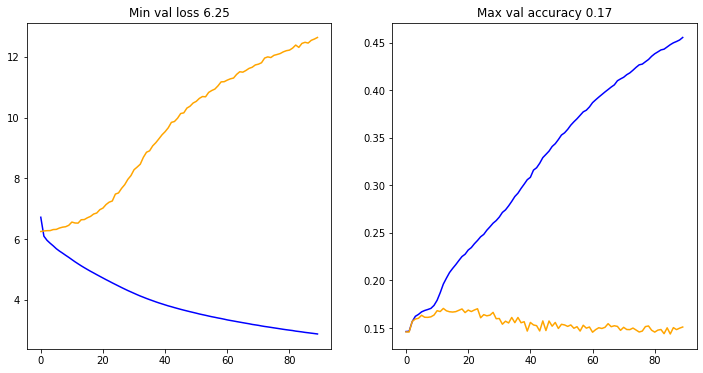

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='test'); plt.title(f'Min val loss {min(history.history["val_loss"]):.2f}')
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='test'); plt.title(f'Max val accuracy {max(history.history["val_accuracy"]):.2f}')

# Text generation

In [ ]:
model = load_model('../models/model.h5',compile=False)
tokenizer = load(open('../models/tokenizer.pkl', 'rb'))

In [ ]:
#index_word = {v:k for k,v in tokenizer.word_index.items()}
def generate_seq(model, seq_length, seed_text, n_words,tokenizer=encode_seq):
    output = []
    text = seed_text
    for _ in range(n_words):
        #encoded = tokenizer.texts_to_sequences([text])[0] # encode the text as integer
        encoded = encode_seq([text], token_indices)[0]
        encoded = pad_sequences([encoded], maxlen=seq_length, truncating='pre') #truncate sequences toa  fixed length (since reinputted)
        yhat = np.argmax(model.predict(encoded), axis=-1) #model.predict_classes(encoded, verbose=False)
        #print(yhat)
        _word = indices_token[yhat[0]] # map predicted word index to word
        if _word == '$':
          return ' '.join(output)
        text += ' ' + _word
        output.append(_word)
        
seq_length = len(train[0].split()) - 1 # also defined as X.shape[1] above
seed_text = train[np.random.randint(0,len(train))]
print(seed_text + '\n')
generated = generate_seq(model, seq_length, seed_text, 20,tokenizer=None)
print(generated)

of / us

forevermore


In [ ]:
for h in h_set:
  if 'hope now your' in h:
    print(h)
    

a man in his car / complains about the traffic / to which he belongs $
